# Content Optimizing

Given an image, we will try to recreate it. To do this we're going to create a VGG network that stops at an intermediate convolution to get an output image and build up the loss function and gradient and then use scipy's optimizer to get the ideal image.

NOTE - We are optimising the input image to reduce loss between output of convolutional layers(compared with output from layers when we pass the style/content image) of VGG16 model(we don't optimise weights since they are pretrained). Also we use the optimized input image as final prediction instead of output from convolutional layers. Usually we train weights and biases of neural network by comparing loss of predictions vs actual answer but in this case we optimise/make changes in the input image and weights are not touched.

In [1]:
import tensorflow as tf
if tf.__version__.startswith('2'):
    tf.compat.v1.disable_eager_execution()

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fmin_l_bfgs_b
from datetime import datetime

In [2]:
def VGG16_AvgPool(shape):
    # we want to account for features across the entire image so get rid of the maxpool which throws away information and use average      # pooling instead.
    vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)

    i = vgg.input
    x = i
    for layer in vgg.layers:
        if layer.__class__ == MaxPooling2D:
            # replace it with average pooling
            x = AveragePooling2D()(x)
        else:
            x = layer(x)

    return Model(i, x)

In [3]:
def VGG16_AvgPool_CutOff(shape, num_convs):
    # this function creates a partial model because we don't need the full VGG network instead we need to stop at an intermediate 
    # convolution. Therefore this function allows us to specify how many convolutions we need
    # there are 13 convolutions in total we can pick any of them as the "output" of our content model

    if num_convs < 1 or num_convs > 13:
        print("num_convs must be in the range [1, 13]")
        return None

    model = VGG16_AvgPool(shape)

    n = 0
    output = None
    for layer in model.layers:
        if layer.__class__ == Conv2D:
            n += 1
        if n >= num_convs:
            output = layer.output
            break

    return Model(model.input, output)

In [4]:
# since VGG accepts BGR this function allows us to convert our values back to RGB so we can plot it using matplotlib
# so this basically reverses the keras function - preprocess input
def unpreprocess(img):
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 126.68
    img = img[..., ::-1]
    return img

def scale_img(x):
    x = x - x.min()
    x = x / x.max()
    return x

# Modelling

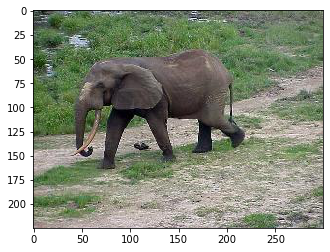

In [5]:
path = 'images/content/elephant.jpg'
img = image.load_img(path)

plt.imshow(img)
plt.show()

In [6]:
# pre-processing
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

batch_shape = x.shape
shape = x.shape[1:]
print(batch_shape)
print(shape)

(1, 225, 300, 3)
(225, 300, 3)


In [7]:
# to make a content model which will give output at the 11th convolutional layers
content_model = VGG16_AvgPool_CutOff(shape, 11)
content_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1:0
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         multiple                  0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 225, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 225, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 150, 64)      0         
______________________________________________________

In [8]:
# symbolic variables

# make the target
target = K.variable(content_model.predict(x))

# try to match the image

# define our loss in keras
loss = K.mean(K.square(target - content_model.output))

# gradients which are needed by the optimizer
grads = K.gradients(loss, content_model.input)

In [9]:
print(target)
print(content_model.input)
print(content_model.output)

<tf.Variable 'Variable:0' shape=(1, 14, 18, 512) dtype=float32>
Tensor("input_1:0", shape=(None, 225, 300, 3), dtype=float32)
Tensor("block5_conv1/Relu:0", shape=(None, 14, 18, 512), dtype=float32)


In [10]:
print(target.shape)
print(content_model.output.shape)
print(content_model.input.shape)

(1, 14, 18, 512)
(None, 14, 18, 512)
(None, 225, 300, 3)


In [11]:
# this callable function takes in a numpy array and returning an array using the symbolic variables we just built
get_loss_and_grads = K.function(
        inputs=[content_model.input],
        outputs=[loss] + grads
    )

In [12]:
def get_loss_and_grads_wrapper(x_vec):
    # this function does the required pre-processing to call the get_loss_and_grads() function and also this function returns loss and     # gradients in the correct shape as required below

    # scipy's minimizer allows us to pass back function value f(x) and its gradient f'(x) simultaneously, rather than using the fprime     # arg
    # we cannot use get_loss_and_grads() directly input to minimizer func must be a 1-D array input to get_loss_and_grads must be          # [batch_of_images]
    # gradient must also be a 1-D array and both loss and gradient must be np.float64, will get an error otherwise
    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)

In [13]:
t0 = datetime.now()

losses = []
x = np.random.randn(np.prod(batch_shape))
for i in range(10):
    # minimizer function
    x, l, _ = fmin_l_bfgs_b(
        func=get_loss_and_grads_wrapper,
        x0=x,
        # bounds=[[-127, 127]]*len(x.flatten()),
        maxfun=20
    )
    x = np.clip(x, -127, 127)
    # print("min:", x.min(), "max:", x.max())
    print("iter=%s, loss=%s" % (i, l))
    losses.append(l)

print("duration:", datetime.now() - t0)

iter=0, loss=957.345458984375
iter=1, loss=365.54364013671875
iter=2, loss=218.42620849609375
iter=3, loss=155.3701171875
iter=4, loss=124.41404724121094
iter=5, loss=102.01370239257812
iter=6, loss=87.51114654541016
iter=7, loss=75.7791748046875
iter=8, loss=66.72642517089844
iter=9, loss=60.03602981567383
duration: 0:00:38.885572


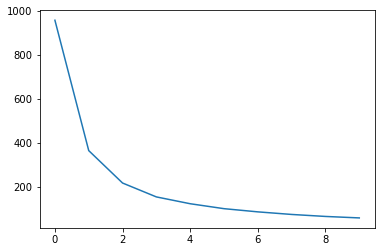

In [14]:
plt.plot(losses)
plt.show()

(1, 225, 300, 3)


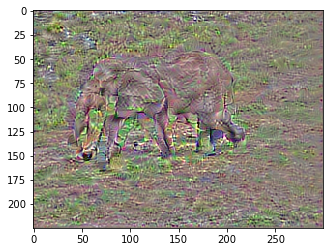

In [15]:
newimg = x.reshape(*batch_shape)
final_img = unpreprocess(newimg)

print(final_img.shape)
plt.imshow(scale_img(final_img[0]))
plt.show()